In [1]:
import os

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.python.client import device_lib

sns.set()

import warnings

warnings.filterwarnings("ignore")

In [2]:
print("--- TEST de présence de CUDA ---")
tensorflow_with_cuda = tf.test.is_built_with_cuda()
print("CUDA dans Tensorflow : " + str(tensorflow_with_cuda))
print(tf.config.list_physical_devices('GPU'))
print(device_lib.list_local_devices())

--- TEST de présence de CUDA ---
CUDA dans Tensorflow : False
[]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10466639451779271369
xla_global_id: -1
]


In [3]:
pizza_dir = './pizza-not-pizza/pizza'
not_pizza_dir = './pizza-not-pizza/not_pizza'
data_dir = './pizza-not-pizza'

In [4]:
epoch = 7

In [5]:
num_pizza_images = len(os.listdir(pizza_dir))
non_pizza_images = len(os.listdir(not_pizza_dir))
print(f'Number of Pizza images: {num_pizza_images}')
print(f'Number of Non-Pizza images: {non_pizza_images}')

Number of Pizza images: 983
Number of Non-Pizza images: 983


In [6]:
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1 / 255., validation_split=0.1)

train_data = data_gen.flow_from_directory(data_dir,
                                          target_size=(224, 224),
                                          batch_size=32,
                                          subset='training',
                                          class_mode='binary')
val_data = data_gen.flow_from_directory(data_dir,
                                        target_size=(224, 224),
                                        batch_size=32,
                                        subset='validation',
                                        class_mode='binary')

Found 1770 images belonging to 2 classes.
Found 196 images belonging to 2 classes.


In [7]:
def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(loss))

    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    ax1 = sns.lineplot(x=epochs, y=loss, label='Training Loss', ax=ax[0])
    ax1 = sns.lineplot(x=epochs, y=val_loss, label='Test Loss', ax=ax[0])
    ax1.set(title='Loss', xlabel='Epochs')

    ax2 = sns.lineplot(x=epochs, y=accuracy, label='Training Accuracy', ax=ax[1])
    ax2 = sns.lineplot(x=epochs, y=val_accuracy, label='Test Accuracy', ax=ax[1])
    ax2.set(title='Accuracy', xlabel='Epochs')

## PMC

Epoch 1/7
56/56 [==============================] - 27s 465ms/step - loss: 9.9246 - accuracy: 0.5667 - val_loss: 5.1768 - val_accuracy: 0.5255
Epoch 2/7
56/56 [==============================] - 25s 445ms/step - loss: 3.1012 - accuracy: 0.6328 - val_loss: 4.7728 - val_accuracy: 0.5102
Epoch 3/7
56/56 [==============================] - 25s 446ms/step - loss: 1.4073 - accuracy: 0.7271 - val_loss: 1.6338 - val_accuracy: 0.6122
Epoch 4/7
56/56 [==============================] - 25s 446ms/step - loss: 0.7443 - accuracy: 0.7718 - val_loss: 1.1348 - val_accuracy: 0.6990
Epoch 5/7
56/56 [==============================] - 25s 449ms/step - loss: 0.5097 - accuracy: 0.8226 - val_loss: 1.4051 - val_accuracy: 0.6684
Epoch 6/7
56/56 [==============================] - 25s 445ms/step - loss: 0.4195 - accuracy: 0.8446 - val_loss: 2.0313 - val_accuracy: 0.6071
Epoch 7/7
56/56 [==============================] - 25s 446ms/step - loss: 0.7713 - accuracy: 0.7898 - val_loss: 1.0419 - val_accuracy: 0.7194


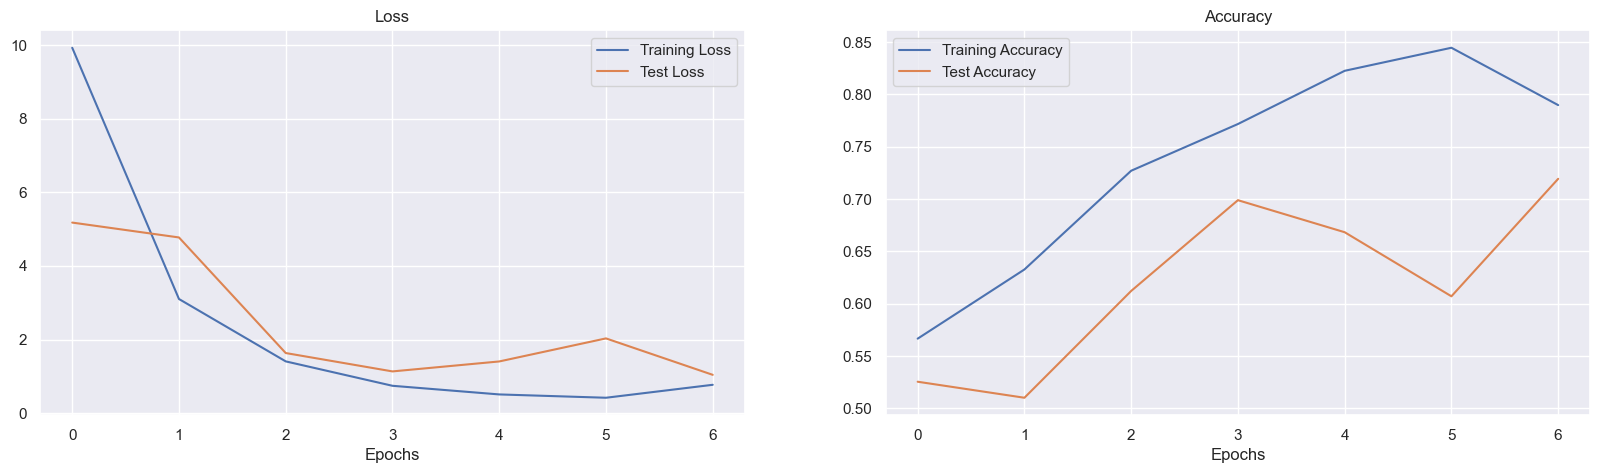

In [11]:
tf.random.set_seed(42)
model_1 = tf.keras.Sequential([
    tf.keras.Input(shape=(224, 224, 3)),  # Input layer
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer
])
model_1.save_weights('model1_init.h5')

model_1.compile(loss=tf.losses.BinaryCrossentropy(),
                optimizer='adam',
                metrics=['accuracy'])

history_1 = model_1.fit(train_data,
                        epochs=epoch,
                        steps_per_epoch=len(train_data),
                        validation_data=val_data,
                        validation_steps=len(val_data))
plot_loss_curves(history_1)

On remarque un surapprentissage avec un Training à 80% et un test à seulement 70%

## CNN

### Convolation sans couche cache

Epoch 1/7
56/56 [==============================] - 26s 455ms/step - loss: 0.6684 - accuracy: 0.6181 - val_loss: 0.6328 - val_accuracy: 0.6378
Epoch 2/7
56/56 [==============================] - 26s 453ms/step - loss: 0.5855 - accuracy: 0.6853 - val_loss: 0.5362 - val_accuracy: 0.7449
Epoch 3/7
56/56 [==============================] - 26s 462ms/step - loss: 0.4759 - accuracy: 0.7859 - val_loss: 0.5289 - val_accuracy: 0.7551
Epoch 4/7
56/56 [==============================] - 25s 445ms/step - loss: 0.3973 - accuracy: 0.8350 - val_loss: 0.5396 - val_accuracy: 0.7398
Epoch 5/7
56/56 [==============================] - 25s 442ms/step - loss: 0.2969 - accuracy: 0.8932 - val_loss: 0.6273 - val_accuracy: 0.7245
Epoch 6/7
56/56 [==============================] - 25s 445ms/step - loss: 0.2208 - accuracy: 0.9277 - val_loss: 0.5450 - val_accuracy: 0.7806
Epoch 7/7
56/56 [==============================] - 25s 442ms/step - loss: 0.1475 - accuracy: 0.9633 - val_loss: 0.6913 - val_accuracy: 0.7143


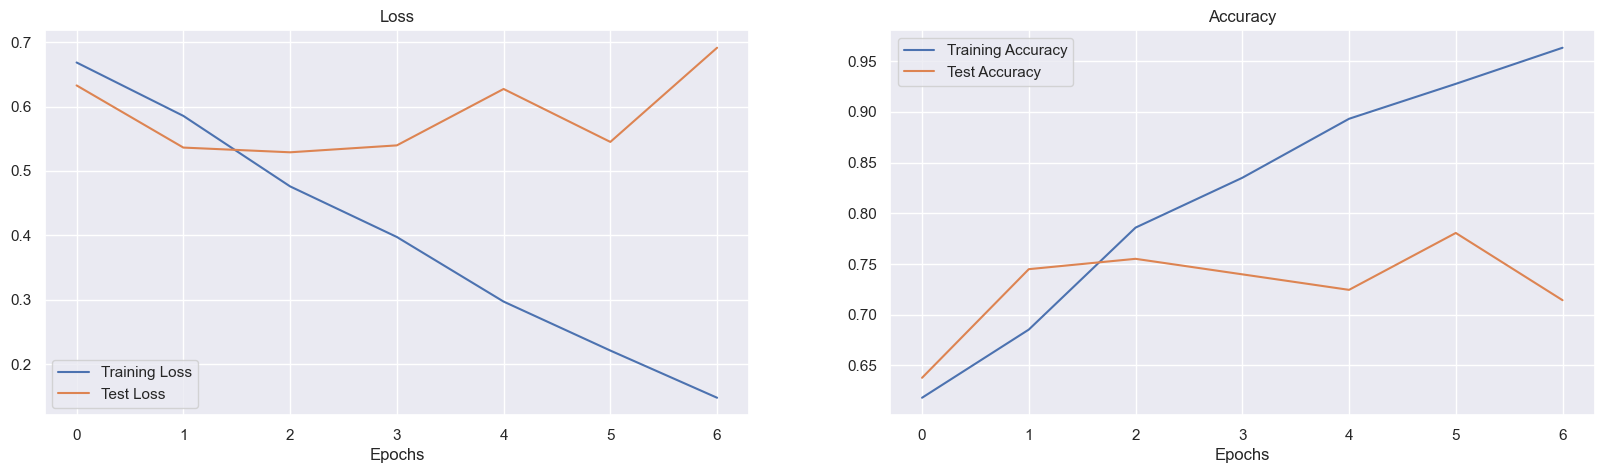

In [12]:
model_2 = tf.keras.Sequential([
    tf.keras.Input(shape=(224, 224, 3)),  # Input layer
    tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='valid', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='valid', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer
])

model_2.save_weights('model2_init.h5')

model_2.compile(loss=tf.losses.BinaryCrossentropy(),
                optimizer='adam',
                metrics=['accuracy'])

history_2 = model_2.fit(train_data,
                        epochs=epoch,
                        steps_per_epoch=len(train_data),
                        validation_data=val_data,
                        validation_steps=len(val_data))
plot_loss_curves(history_2)

On remarque avec un convolution un surapprentissage moins important ainsi qu'un pourcentage de réussite plus important sur la validation.

### Convolution avec couche cache

Epoch 1/7
56/56 [==============================] - 28s 493ms/step - loss: 0.7059 - accuracy: 0.5932 - val_loss: 0.6287 - val_accuracy: 0.6531
Epoch 2/7
56/56 [==============================] - 26s 470ms/step - loss: 0.5754 - accuracy: 0.6983 - val_loss: 0.5414 - val_accuracy: 0.7602
Epoch 3/7
56/56 [==============================] - 26s 465ms/step - loss: 0.5433 - accuracy: 0.7203 - val_loss: 0.5432 - val_accuracy: 0.7551
Epoch 4/7
56/56 [==============================] - 26s 466ms/step - loss: 0.5197 - accuracy: 0.7441 - val_loss: 0.5925 - val_accuracy: 0.6633
Epoch 5/7
56/56 [==============================] - 25s 450ms/step - loss: 0.4760 - accuracy: 0.7876 - val_loss: 0.4969 - val_accuracy: 0.8163
Epoch 6/7
56/56 [==============================] - 25s 449ms/step - loss: 0.4219 - accuracy: 0.8220 - val_loss: 0.4751 - val_accuracy: 0.7755
Epoch 7/7
56/56 [==============================] - 25s 455ms/step - loss: 0.3825 - accuracy: 0.8458 - val_loss: 0.4920 - val_accuracy: 0.7551


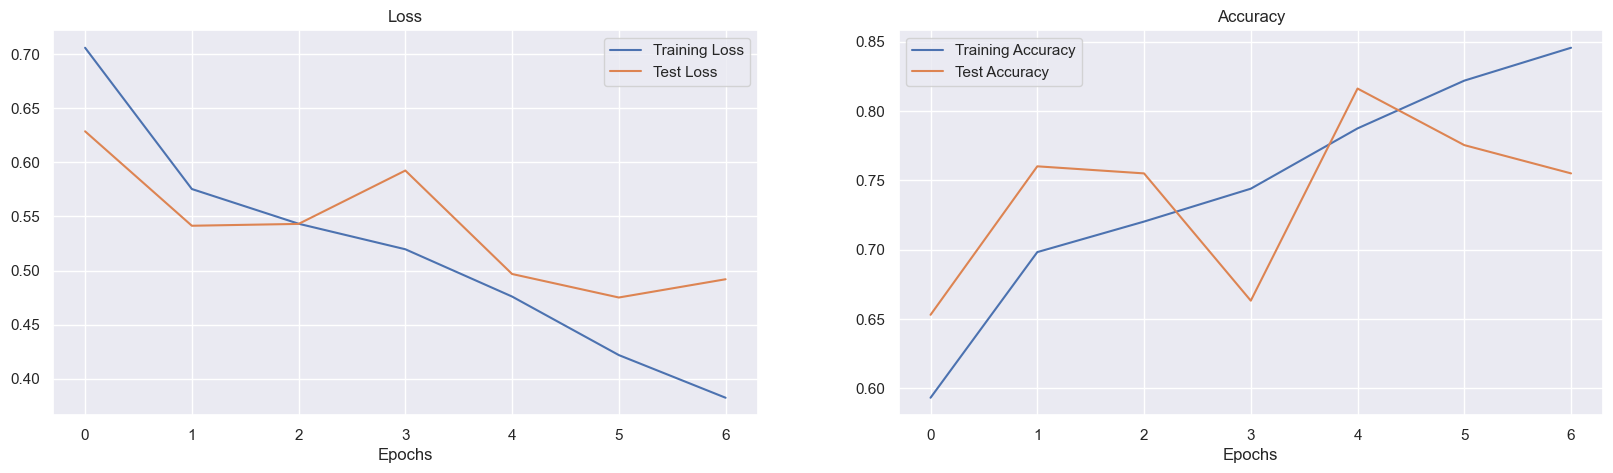

In [13]:
model_3 = tf.keras.Sequential([
    tf.keras.Input(shape=(224, 224, 3)),  # Input layer
    tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='valid', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='valid', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer
])

model_3.save_weights('model3_init.h5')

model_3.compile(loss=tf.losses.BinaryCrossentropy(),
                optimizer='adam',
                metrics=['accuracy'])

history_3 = model_3.fit(train_data,
                        epochs=epoch,
                        steps_per_epoch=len(train_data),
                        validation_data=val_data,
                        validation_steps=len(val_data))
plot_loss_curves(history_3)

Ici, une couche caché ne nous apporte pas grand chose

## Data Augmentation

In [14]:
# Defining data generator with Data Augmentation
data_gen_augmented = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1 / 255.,
                                                                     validation_split=0.2,
                                                                     zoom_range=0.2,
                                                                     horizontal_flip=True,
                                                                     rotation_range=20,
                                                                     width_shift_range=0.2,
                                                                     height_shift_range=0.2)

print('Augmented training Images:')
train_data_augmented = data_gen_augmented.flow_from_directory(data_dir,
                                                              target_size=(224, 224),
                                                              batch_size=32,
                                                              subset='training',
                                                              class_mode='binary')

print('Unchanged Validation Images:')
val_data = data_gen.flow_from_directory(data_dir,
                                        target_size=(224, 224),
                                        batch_size=32,
                                        subset='validation',
                                        class_mode='binary')

Augmented training Images:
Found 1574 images belonging to 2 classes.
Unchanged Validation Images:
Found 196 images belonging to 2 classes.


### PMC

Epoch 1/7
50/50 [==============================] - 25s 494ms/step - loss: 9.6715 - accuracy: 0.5750 - val_loss: 1.5875 - val_accuracy: 0.6582
Epoch 2/7
50/50 [==============================] - 25s 490ms/step - loss: 2.6375 - accuracy: 0.5921 - val_loss: 1.2977 - val_accuracy: 0.6276
Epoch 3/7
50/50 [==============================] - 25s 488ms/step - loss: 1.8379 - accuracy: 0.5947 - val_loss: 1.1667 - val_accuracy: 0.6378
Epoch 4/7
50/50 [==============================] - 25s 489ms/step - loss: 1.7699 - accuracy: 0.5826 - val_loss: 1.2992 - val_accuracy: 0.6531
Epoch 5/7
50/50 [==============================] - 25s 502ms/step - loss: 1.5107 - accuracy: 0.5915 - val_loss: 0.9701 - val_accuracy: 0.7143
Epoch 6/7
50/50 [==============================] - 26s 525ms/step - loss: 1.0644 - accuracy: 0.6156 - val_loss: 0.7739 - val_accuracy: 0.6786
Epoch 7/7
50/50 [==============================] - 26s 510ms/step - loss: 0.7526 - accuracy: 0.6487 - val_loss: 0.8603 - val_accuracy: 0.6327
Le pre

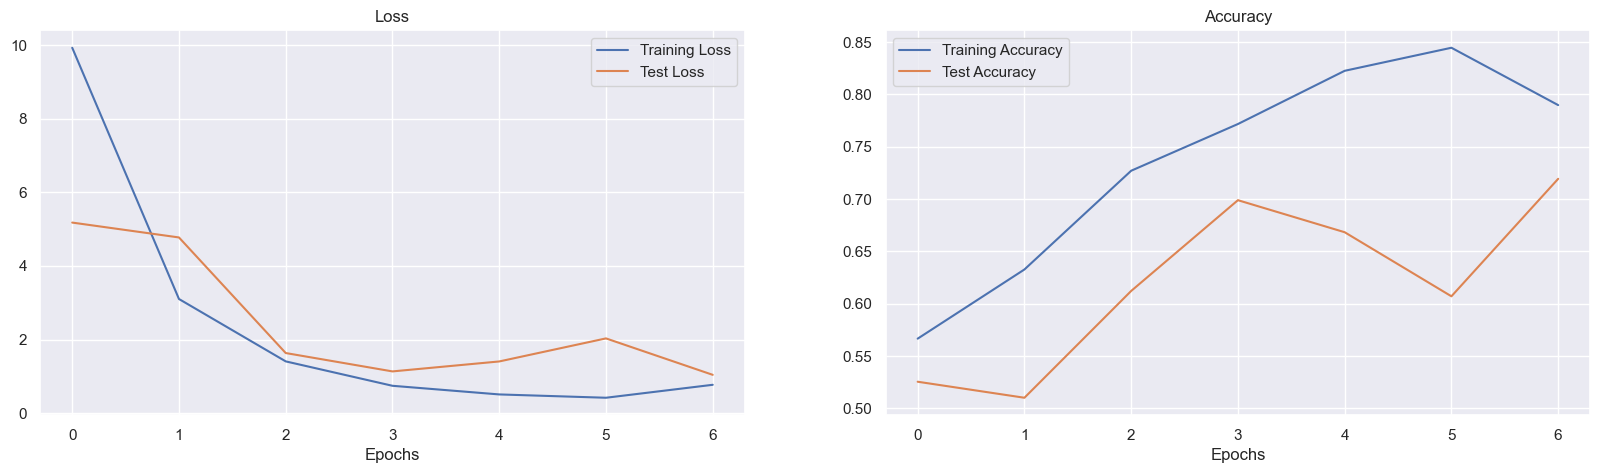

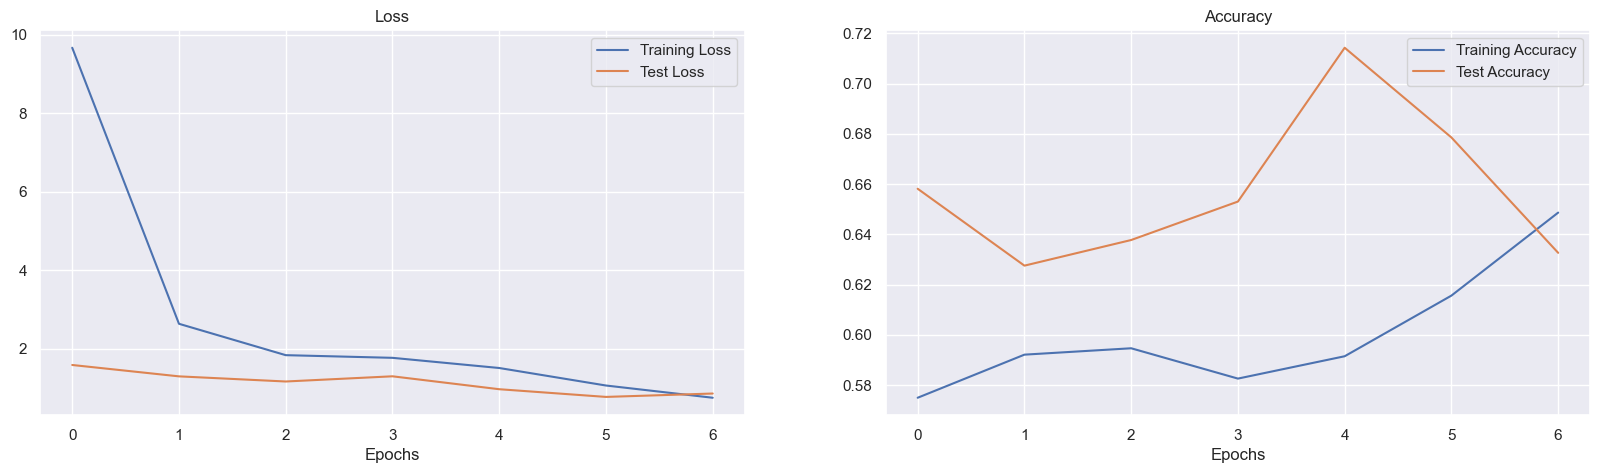

In [15]:
model_1.load_weights('model1_init.h5')
model_1.compile(loss=tf.losses.BinaryCrossentropy(),
                optimizer='adam',
                metrics=['accuracy'])

history_1_1 = model_1.fit(train_data_augmented,
                          epochs=epoch,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=val_data,
                          validation_steps=len(val_data))
print("Le premier graphique correspond aux données normales, le second au données augmentées")
plot_loss_curves(history_1)
plot_loss_curves(history_1_1)

### CNN sans couche

Epoch 1/7
50/50 [==============================] - 27s 522ms/step - loss: 0.7985 - accuracy: 0.5457 - val_loss: 0.6412 - val_accuracy: 0.6888
Epoch 2/7
50/50 [==============================] - 26s 517ms/step - loss: 0.6274 - accuracy: 0.6372 - val_loss: 0.5965 - val_accuracy: 0.6990
Epoch 3/7
50/50 [==============================] - 27s 532ms/step - loss: 0.6091 - accuracy: 0.6785 - val_loss: 0.6428 - val_accuracy: 0.6378
Epoch 4/7
50/50 [==============================] - 26s 517ms/step - loss: 0.5764 - accuracy: 0.6925 - val_loss: 0.5304 - val_accuracy: 0.7704
Epoch 5/7
50/50 [==============================] - 26s 525ms/step - loss: 0.6106 - accuracy: 0.6747 - val_loss: 0.5387 - val_accuracy: 0.7449
Epoch 6/7
50/50 [==============================] - 27s 531ms/step - loss: 0.5768 - accuracy: 0.6919 - val_loss: 0.5573 - val_accuracy: 0.7296
Epoch 7/7
50/50 [==============================] - 27s 530ms/step - loss: 0.5613 - accuracy: 0.7078 - val_loss: 0.7120 - val_accuracy: 0.6276
Le pre

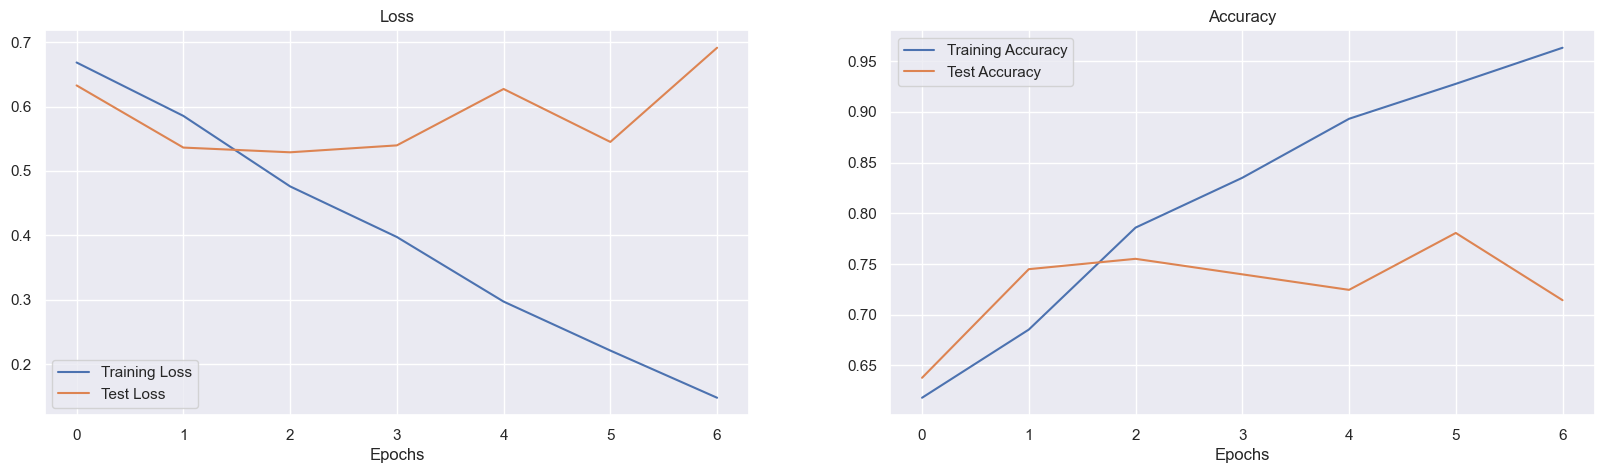

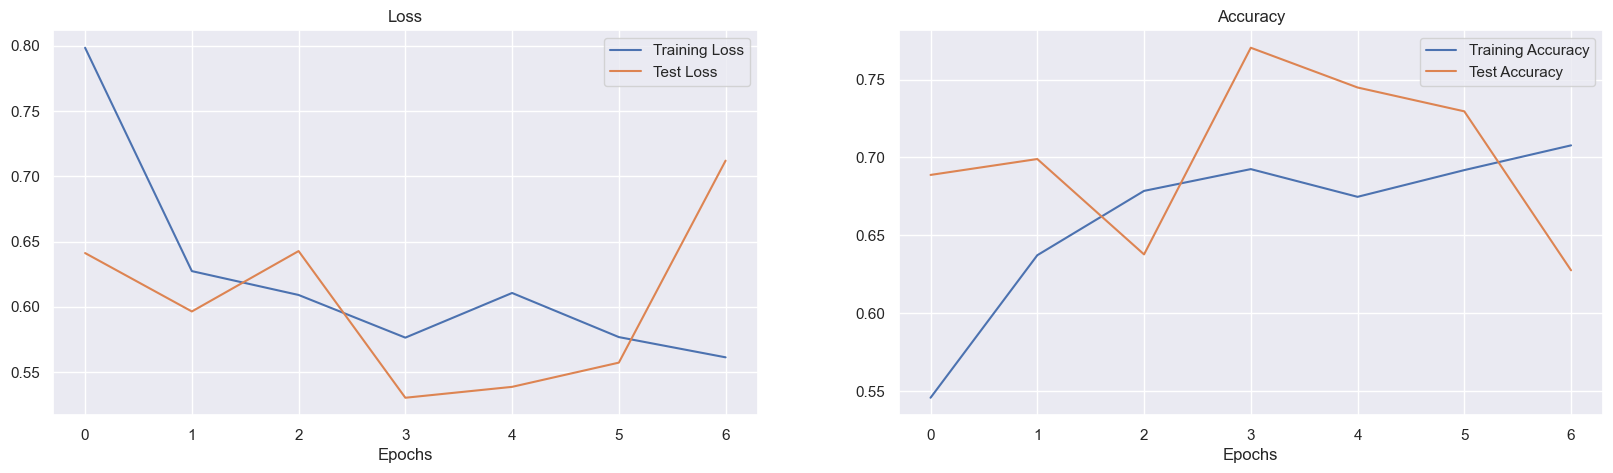

In [16]:
model_2.load_weights('model2_init.h5')
model_2.compile(loss=tf.losses.BinaryCrossentropy(),
                optimizer='adam',
                metrics=['accuracy'])

history_2_1 = model_2.fit(train_data_augmented,
                          epochs=epoch,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=val_data,
                          validation_steps=len(val_data))

print("Le premier graphique correspond aux données normales, le second au données augmentées")
plot_loss_curves(history_2)
plot_loss_curves(history_2_1)

### CNN avec couche

Epoch 1/7
50/50 [==============================] - 27s 532ms/step - loss: 0.6810 - accuracy: 0.5851 - val_loss: 0.6685 - val_accuracy: 0.5204
Epoch 2/7
50/50 [==============================] - 26s 523ms/step - loss: 0.6495 - accuracy: 0.6163 - val_loss: 0.6083 - val_accuracy: 0.6939
Epoch 3/7
50/50 [==============================] - 27s 529ms/step - loss: 0.6198 - accuracy: 0.6620 - val_loss: 0.5827 - val_accuracy: 0.7041
Epoch 4/7
50/50 [==============================] - 27s 537ms/step - loss: 0.5780 - accuracy: 0.7052 - val_loss: 0.5228 - val_accuracy: 0.7347
Epoch 5/7
50/50 [==============================] - 27s 528ms/step - loss: 0.5957 - accuracy: 0.6804 - val_loss: 0.5369 - val_accuracy: 0.7347
Epoch 6/7
50/50 [==============================] - 27s 527ms/step - loss: 0.5706 - accuracy: 0.7166 - val_loss: 0.5416 - val_accuracy: 0.7296
Epoch 7/7
50/50 [==============================] - 26s 527ms/step - loss: 0.5433 - accuracy: 0.7389 - val_loss: 0.5862 - val_accuracy: 0.7398
Le pre

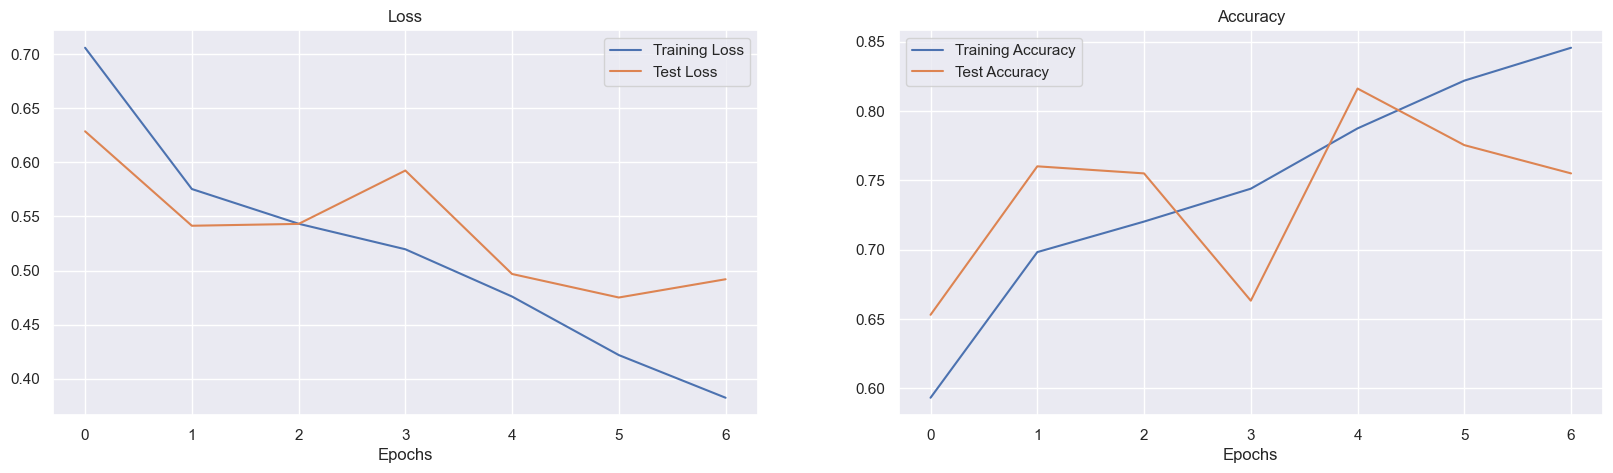

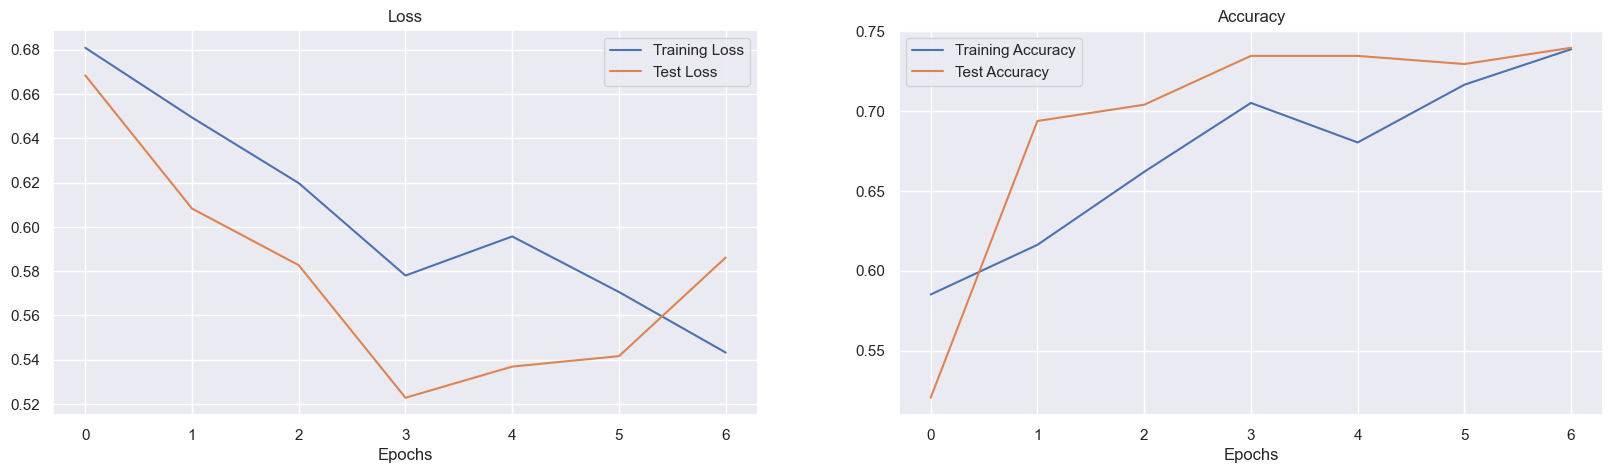

In [17]:
model_3.load_weights('model3_init.h5')
model_3.compile(loss=tf.losses.BinaryCrossentropy(),
                optimizer='adam',
                metrics=['accuracy'])

history_3_1 = model_3.fit(train_data_augmented,
                          epochs=epoch,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=val_data,
                          validation_steps=len(val_data))
print("Le premier graphique correspond aux données normales, le second au données augmentées")
plot_loss_curves(history_3)
plot_loss_curves(history_3_1)

## Transfer Learning

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Epoch 1/3
56/56 [==============================] - 310s 5s/step - loss: 0.2362 - accuracy: 0.9441 - val_loss: 0.1489 - val_accuracy: 0.9490
Epoch 2/3
56/56 [==============================] - 305s 5s/step - loss: 0.1152 - accuracy: 0.9610 - val_loss: 0.1332 - val_accuracy: 0.9541
Epoch 3/3
56/56 [==============================] - 313s 6s/step - loss: 0.0976 - accuracy: 0.9650 - val_loss: 0.1275 - val_accuracy: 0.9541


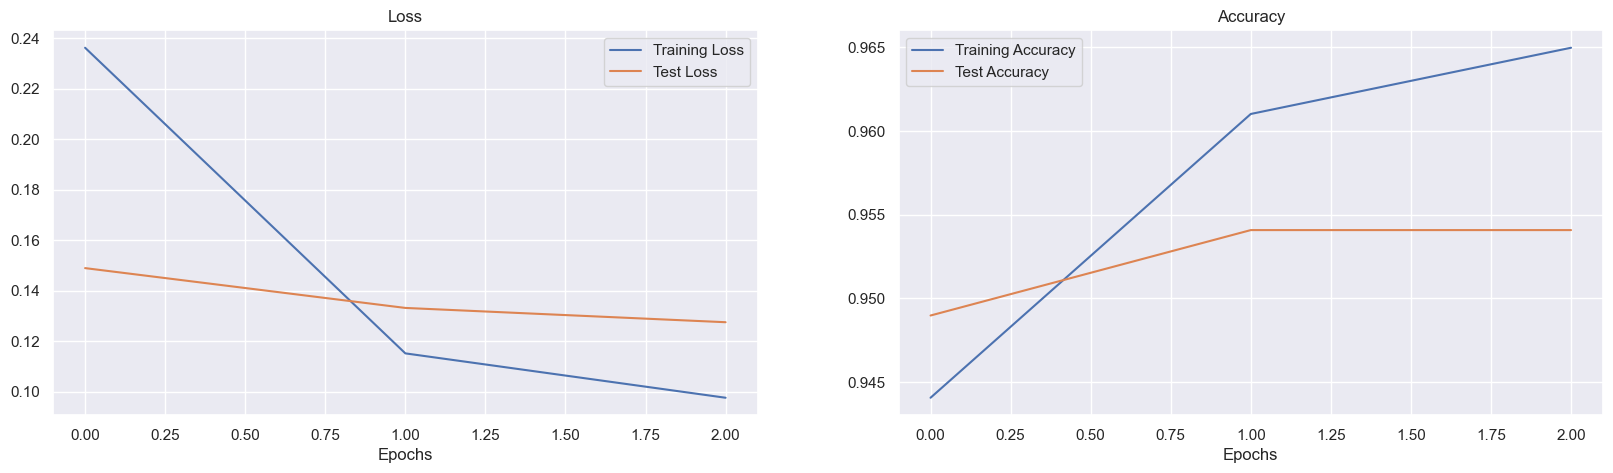

In [19]:
url = 'https://tfhub.dev/google/efficientnet/b7/feature-vector/1'

feature_extractor_layer = hub.KerasLayer(url,
                                         trainable=False,
                                         input_shape=(224, 224, 3))

model_vgg = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_vgg.compile(loss=tf.losses.BinaryCrossentropy(),
                  optimizer='adam',
                  metrics=['accuracy'])

history_vgg = model_vgg.fit(train_data,
                            epochs=3,
                            steps_per_epoch=len(train_data),
                            validation_data=val_data,
                            validation_steps=len(val_data))
plot_loss_curves(history_vgg)


## Inception

Epoch 1/12
50/50 [==============================] - 15s 256ms/step - loss: 0.8892 - accuracy: 0.7637 - val_loss: 0.1491 - val_accuracy: 0.9286
Epoch 2/12
50/50 [==============================] - 12s 246ms/step - loss: 0.4627 - accuracy: 0.8615 - val_loss: 0.1769 - val_accuracy: 0.9337
Epoch 3/12
50/50 [==============================] - 12s 248ms/step - loss: 0.3033 - accuracy: 0.8926 - val_loss: 0.2859 - val_accuracy: 0.9031
Epoch 4/12
50/50 [==============================] - 12s 247ms/step - loss: 0.2530 - accuracy: 0.9104 - val_loss: 0.3600 - val_accuracy: 0.8827
Epoch 5/12
50/50 [==============================] - 13s 250ms/step - loss: 0.2264 - accuracy: 0.9136 - val_loss: 0.1616 - val_accuracy: 0.9490
Epoch 6/12
50/50 [==============================] - 13s 254ms/step - loss: 0.2386 - accuracy: 0.9149 - val_loss: 0.3996 - val_accuracy: 0.8418
Epoch 7/12
50/50 [==============================] - 13s 249ms/step - loss: 0.2195 - accuracy: 0.9276 - val_loss: 0.3806 - val_accuracy: 0.8776

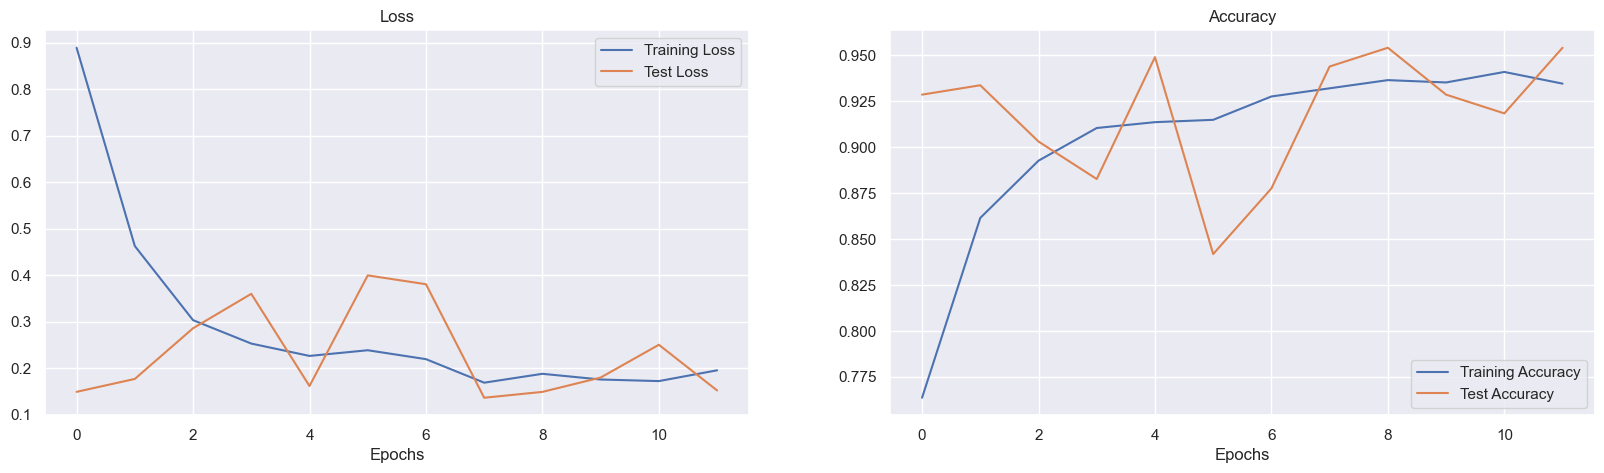

In [26]:

from keras.optimizers import RMSprop
from keras import Model
from keras.applications import InceptionV3
from keras import layers

resnet_pretrain_model = InceptionV3(input_shape = (224, 224, 3),
                                    include_top = False,
                                    weights = "imagenet")
for layer in resnet_pretrain_model.layers:
     layer.trainable = False

last_layer = resnet_pretrain_model.get_layer('mixed7')
last_output = last_layer.output
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(6, activation='softmax')(x)

resnet_model = Model(resnet_pretrain_model.input, x)

resnet_model.compile(optimizer = RMSprop(lr=0.0001),
                     loss = 'sparse_categorical_crossentropy',
                     metrics = ['accuracy'])

history=resnet_model.fit(train_data_augmented,
                         epochs=12,
                         steps_per_epoch=len(train_data_augmented),
                         validation_data=val_data,
                         validation_steps=len(val_data))
plot_loss_curves(history)

## VGG16

Epoch 1/12
50/50 [==============================] - 13s 255ms/step - loss: 1.2041 - accuracy: 0.6550 - val_loss: 0.7142 - val_accuracy: 0.7143
Epoch 2/12
50/50 [==============================] - 13s 250ms/step - loss: 0.5713 - accuracy: 0.7637 - val_loss: 0.3944 - val_accuracy: 0.8316
Epoch 3/12
50/50 [==============================] - 13s 257ms/step - loss: 0.5258 - accuracy: 0.7795 - val_loss: 0.3240 - val_accuracy: 0.8622
Epoch 4/12
50/50 [==============================] - 13s 256ms/step - loss: 0.4394 - accuracy: 0.8196 - val_loss: 0.2775 - val_accuracy: 0.8878
Epoch 5/12
50/50 [==============================] - 13s 252ms/step - loss: 0.4267 - accuracy: 0.8247 - val_loss: 0.3807 - val_accuracy: 0.8061
Epoch 6/12
50/50 [==============================] - 13s 253ms/step - loss: 0.3973 - accuracy: 0.8310 - val_loss: 0.2199 - val_accuracy: 0.9184
Epoch 7/12
50/50 [==============================] - 13s 261ms/step - loss: 0.3522 - accuracy: 0.8520 - val_loss: 0.4855 - val_accuracy: 0.7806

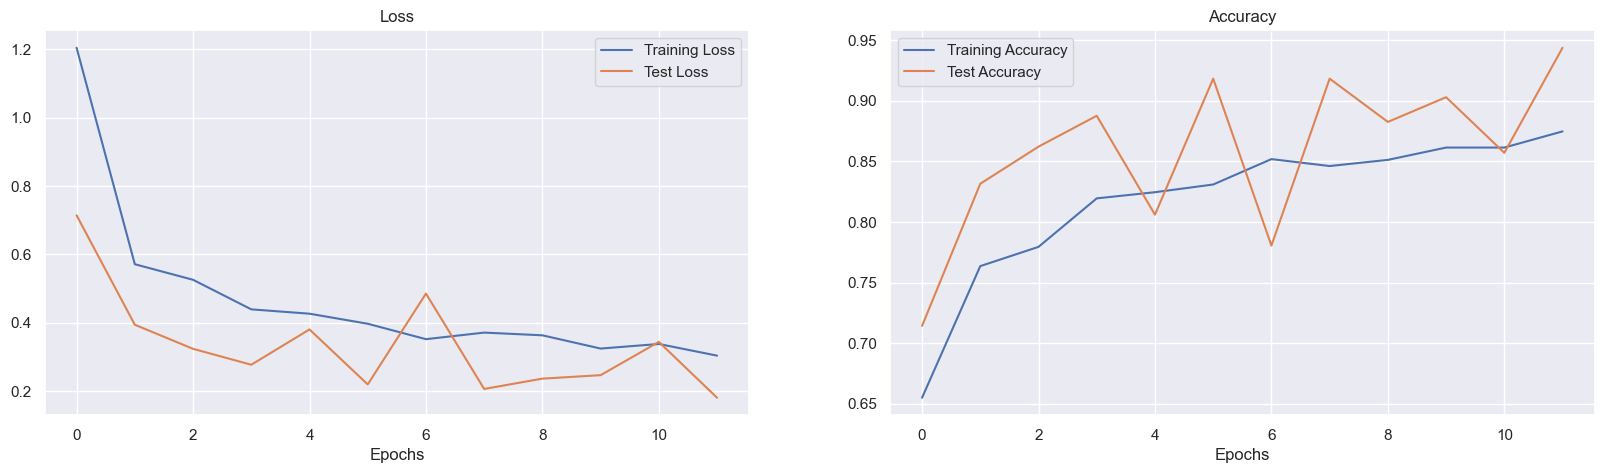

In [27]:
from keras.optimizers import RMSprop
from keras import Model
from keras.applications import VGG16
from keras import layers

resnet_pretrain_model = VGG16(input_shape = (224, 224, 3),
                              include_top = False,
                              weights = "imagenet")
for layer in resnet_pretrain_model.layers:
     layer.trainable = False

last_layer = resnet_pretrain_model.get_layer('block5_pool')
last_output = last_layer.output
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(6, activation='softmax')(x)

resnet_model = Model(resnet_pretrain_model.input, x)

resnet_model.compile(optimizer = RMSprop(lr=0.0001),
                     loss = 'sparse_categorical_crossentropy',
                     metrics = ['accuracy'])

history=resnet_model.fit(train_data_augmented,
                         epochs=12,
                         steps_per_epoch=len(train_data_augmented),
                         validation_data=val_data,
                         validation_steps=len(val_data))
plot_loss_curves(history)

Au bout de 3 epochs, l'apprentissage se stabilise
Feature vectors of EfficientNet models trained on Imagenet


# Training

In [1]:
import torch

torch.cuda.get_device_name(0)


'NVIDIA GeForce RTX 3060'

In [1]:
!git clone https://github.com/ultralytics/yolov5
!git clone https://github.com/sergiovirahonda/FaceMaskDataset

Cloning into 'FaceMaskDataset'...
Updating files:  17% (1649/9557)
Updating files:  18% (1721/9557)
Updating files:  19% (1816/9557)
Updating files:  20% (1912/9557)
Updating files:  21% (2007/9557)
Updating files:  22% (2103/9557)
Updating files:  23% (2199/9557)
Updating files:  24% (2294/9557)
Updating files:  25% (2390/9557)
Updating files:  26% (2485/9557)
Updating files:  27% (2581/9557)
Updating files:  28% (2676/9557)
Updating files:  29% (2772/9557)
Updating files:  30% (2868/9557)
Updating files:  31% (2963/9557)
Updating files:  32% (3059/9557)
Updating files:  32% (3098/9557)
Updating files:  33% (3154/9557)
Updating files:  34% (3250/9557)
Updating files:  35% (3345/9557)
Updating files:  36% (3441/9557)
Updating files:  37% (3537/9557)
Updating files:  38% (3632/9557)
Updating files:  39% (3728/9557)
Updating files:  40% (3823/9557)
Updating files:  41% (3919/9557)
Updating files:  41% (3931/9557)
Updating files:  42% (4014/9557)
Updating files:  43% (4110/9557)
Updating 

In [1]:
%cd yolov5

C:\var\TransferLearning\yolov5


In [2]:
!pip install -r requirements.txt

  Using cached matplotlib-3.6.2-cp310-cp310-win_amd64.whl (7.2 MB)
  Using cached numpy-1.23.4-cp310-cp310-win_amd64.whl (14.6 MB)
  Using cached opencv_python-4.6.0.66-cp36-abi3-win_amd64.whl (35.6 MB)
  Using cached Pillow-9.3.0-cp310-cp310-win_amd64.whl (2.5 MB)
  Using cached PyYAML-6.0-cp310-cp310-win_amd64.whl (151 kB)
  Using cached requests-2.28.1-py3-none-any.whl (62 kB)
  Using cached scipy-1.9.3-cp310-cp310-win_amd64.whl (40.1 MB)
  Using cached thop-0.1.1.post2209072238-py3-none-any.whl (15 kB)
  Using cached torch-1.13.0-cp310-cp310-win_amd64.whl (167.3 MB)
  Using cached torchvision-0.14.0-cp310-cp310-win_amd64.whl (1.1 MB)
  Using cached tqdm-4.64.1-py2.py3-none-any.whl (78 kB)
  Using cached pandas-1.5.1-cp310-cp310-win_amd64.whl (10.4 MB)
  Using cached seaborn-0.12.1-py3-none-any.whl (288 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached contourpy-1.0.6-cp310-cp310-win_amd64.whl (163 kB)
  Using cached fonttools-4.38.0-py3-none-any.whl (965 kB)

You should consider upgrading via the 'C:\var\TransferLearning\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
!python train.py --img 415 --data dataset.yaml --epochs 2 --weights yolov5n.pt  --batch-size 128 --device 0

^C


Cette partie a été exécutée sur Google Collab car elle ne fonctionnait pas sur l'ordinateur pour une raison inconnue. Les poids ont ensuite été téléchargé et
ajouté à la suite du projet

In [2]:
!python detect.py --weights best_m.pt --img 640 --conf 0.25 --source masques.mp4

detect: weights=['best_m.pt'], source=masques.mp4, data=data\coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs\detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5  v6.2-239-gf33718f Python-3.10.2 torch-1.13.0+cu116 CUDA:0 (NVIDIA GeForce RTX 3060, 12287MiB)

Fusing layers... 
Model summary: 212 layers, 20856975 parameters, 0 gradients, 47.9 GFLOPs
video 1/1 (1/4947) C:\var\TransferLearning\yolov5\masques.mp4: 384x640 1 face mask, 15.0ms
video 1/1 (2/4947) C:\var\TransferLearning\yolov5\masques.mp4: 384x640 1 face mask, 10.0ms
video 1/1 (3/4947) C:\var\TransferLearning\yolov5\masques.mp4: 384x640 1 face mask, 10.0ms
video 1/1 (4/4947) C:\var\TransferLearning\yolov5\masques.mp4: 384x640 1 face mask, 9.5